## To see the effect of offset cut on convolution/stacking

- Make maps with FoV cut
- Stack and then convolve
- OR convolve and then stack

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap, Map
from gammapy.cube import MapMaker
from gammapy.data import DataStore
from astropy.convolution import Tophat2DKernel

In [2]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps/")

In [3]:
obs_ids = [110380, 111140]
observations = data_store.get_observations(obs_ids)

In [4]:
energy_axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 2), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(15, 15),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

### 1. Make maps with FoV offset cut

In [17]:
%%time
maps = []

offset_max = 3.0 * u.deg
for i in range(len(obs_ids)):
    maker = MapMaker(geom, offset_max=offset_max)
    map_obs = maker.run(observations[i:i+1])
    maps.append(map_obs)

CPU times: user 4.29 s, sys: 221 ms, total: 4.51 s
Wall time: 1.19 s


### 2 (a) Stack and then convolve

In [18]:
stack_count = WcsNDMap(geom)
for i in range(len(observations)):
    stack_count.data = stack_count.data + maps[i]["counts"].data

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1c1ad912b0>)

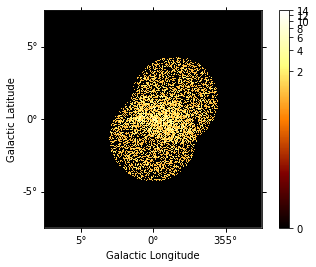

In [19]:
stack_count.get_image_by_idx([0]).plot(add_cbar=True, stretch="log")

In [20]:
tophat = Tophat2DKernel(4)
tophat.normalize("peak")
stack_convolve = stack_count.convolve(tophat.array)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x11659f630>)

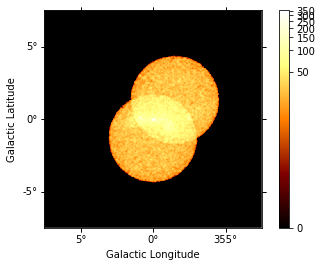

In [21]:
stack_convolve.get_image_by_idx([0]).plot(add_cbar=True, stretch="log")

### 2(b) convolve and then stack

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1c1bb8c208>)

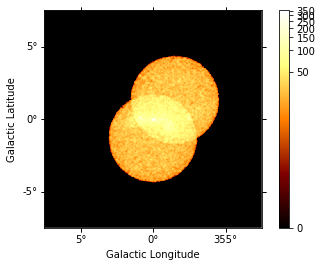

In [22]:
conv_stack = WcsNDMap(geom)
for i in range(len(observations)):
    map_conv = maps[i]["counts"].convolve(tophat.array)
    conv_stack.data = conv_stack.data + map_conv.data
conv_stack.get_image_by_idx([0]).plot(add_cbar=True, stretch="log")

In [23]:
conv_stack.data.sum()

4019274.0

In [24]:
stack_convolve.data.sum()

4019274.0

In [25]:
diff = conv_stack - stack_convolve

In [26]:
diff.data.sum()

0.03294383

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1c1bd17f98>)

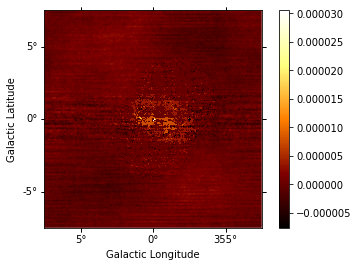

In [27]:
diff.get_image_by_idx([0]).plot(add_cbar=True)

In [28]:
diff.data.sum()

0.03294383